In [3]:
''' 
BORUTA RUSBOOST BINARY
'''
import pandas as pd
def FoundFeatures(Path):
    # reading the found dataset for the training
    df = pd.read_excel(Path)
    Features = set(df.columns)
    return Features

# removing the id and the subtypes of a given dataset
def extract_PATIENT_INFO(db):
    ids =  db.pop("ID")
    morf_codificata = db.pop("morf_codificata")
    luogo_tc = db.pop("luogoTC_codificato")
    return db, ids, morf_codificata, luogo_tc

In [2]:
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from Models import Boruta_RusBoost
from sklearn.metrics import  accuracy_score, confusion_matrix,precision_score, recall_score, f1_score,roc_auc_score,roc_curve,precision_recall_curve, average_precision_score


# create dataset

or_db = pd.read_excel("Dataset/Cleaned_dataset.xlsx")
db = or_db[or_db["luogoTC_codificato"] == 1]
val_set = or_db[or_db["luogoTC_codificato"] != 1]

 # extrating the label
y = db.pop("maligno")
X = db
print(X.shape)
# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
# enumerate splits
outer_results = list()
best_params_per_fold = []
scores = pd.DataFrame(columns=['Outer Fold',"Grid-Search",'F1-score', 'Recall', 'Precision', 'Accuracy', 'Auc-Score', '#Features'])


train_folds = []
test_folds = []

for index, (train_ix, test_ix) in enumerate(cv_outer.split(X, y)):
	# split data
	X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
	y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

	train_folds.append(X_train.copy())
	test_folds.append(X_test.copy())
	# configure the cross-validation procedure
	cv_inner = StratifiedKFold(n_splits=5,shuffle = True, random_state=42)
	
	pipeline = Boruta_RusBoost.Define_Pipeline()
	X_train, ids, morf_codificata, luogo_tc_train = extract_PATIENT_INFO(X_train)
	Grid_searchOBJ = Boruta_RusBoost.Grid_Search(pipeline=pipeline, cv = cv_inner, X_train=X_train, y_train=y_train)

	best_params = Grid_searchOBJ.best_params_
	best_params_per_fold.append(Grid_searchOBJ.best_params_)
	print(f"Fold {len(best_params_per_fold)}: Best Params = {Grid_searchOBJ.best_params_}")

	Chosen_pipeline = Boruta_RusBoost.Define_Pipeline()
	Chosen_pipeline.set_params(**Grid_searchOBJ.best_params_)
	fitted_pipeline = Boruta_RusBoost.fit(pipeline=Chosen_pipeline, X_train=X_train, y_train=y_train, Prefix="AcrossSplits/Split{}_".format(index))
	X_test, ids_test, morf_codificata_test, luogo_tc_test = extract_PATIENT_INFO(X_test)
	predictions = fitted_pipeline.predict(X_test)
	probs = fitted_pipeline.predict_proba(X_test)

	###Metrics
	Accuracy = round(accuracy_score(y_test, predictions),3)
	precision = round(precision_score(y_test, predictions),3)
	recall = round(recall_score(y_test, predictions),3)
	f1 = round(f1_score(y_test, predictions),3)
	print("F1 Test is", f1)
	probs = probs[:, 1]
	auc_roc = round(roc_auc_score(y_test,probs),3)

	##Features
	AllFeaturesBoruta_RusBoost = FoundFeatures("./Elements/Boruta_RusBoost/AcrossSplits/Split{}_Boruta_RusBoost_ReduceDataset.xlsx".format(index))
	print("it has found {} features".format(len(AllFeaturesBoruta_RusBoost)))
	
	new_row = [index,Grid_searchOBJ.best_score_, f1, recall, precision, Accuracy, auc_roc, len(AllFeaturesBoruta_RusBoost)]  
	scores.loc[index] = new_row  # Append the new row
    
scores["Outer Fold"] = scores["Outer Fold"].astype(int)
scores["#Features"] = scores["#Features"].astype(int)
scores.to_csv('Elements/Boruta_RusBoost/AcrossSplits/scores.csv', index=False)  # index=False to avoid saving the row numbers
scores

(537, 127)
[2024-11-09 17:43:50,833: INFO: Boruta_RusBoost: Defining the Pipeline...]
[2024-11-09 17:43:50,834: INFO: Boruta_RusBoost: Let's define the cross validation:StratifiedKFold(n_splits=5, random_state=42, shuffle=True)]
[2024-11-09 17:43:50,835: INFO: Boruta_RusBoost: Let's define the parameters for the grid search: {'feature_selection__estimator': [RandomForestClassifier(random_state=42)], 'feature_selection__estimator__n_estimators': [50, 100], 'feature_selection__estimator__max_depth': [3, 5], 'rusboostclassifier__n_estimators': [150, 300], 'rusboostclassifier__learning_rate': [0.05, 0.01]}]
Best: 0.813545 using {'feature_selection__estimator': RandomForestClassifier(random_state=42), 'feature_selection__estimator__max_depth': 5, 'feature_selection__estimator__n_estimators': 50, 'rusboostclassifier__learning_rate': 0.05, 'rusboostclassifier__n_estimators': 300}
Fold 1: Best Params = {'feature_selection__estimator': RandomForestClassifier(random_state=42), 'feature_selection

,Outer Fold,Grid-Search,F1-score,Recall,Precision,Accuracy,Auc-Score,#Features
0,0,0.813545,0.712,0.913,0.583,0.843,0.957,38
1,1,0.794160,0.745,0.826,0.679,0.880,0.944,35
2,2,0.773668,0.800,0.957,0.688,0.897,0.971,31
3,3,0.795542,0.840,0.913,0.778,0.925,0.963,33
4,4,0.793223,0.824,0.913,0.750,0.916,0.952,37


In [3]:
scores
	

,Outer Fold,Grid-Search,F1-score,Recall,Precision,Accuracy,Auc-Score,#Features
0,0,0.813545,0.712,0.913,0.583,0.843,0.957,38
1,1,0.794160,0.745,0.826,0.679,0.880,0.944,35
2,2,0.773668,0.800,0.957,0.688,0.897,0.971,31
3,3,0.795542,0.840,0.913,0.778,0.925,0.963,33
4,4,0.793223,0.824,0.913,0.750,0.916,0.952,37


In [4]:
best_params_per_fold 

[{'feature_selection__estimator': RandomForestClassifier(max_depth=5, n_estimators=1000,
                         random_state=RandomState(MT19937) at 0x714442A59440),
  'feature_selection__estimator__max_depth': 5,
  'feature_selection__estimator__n_estimators': 50,
  'rusboostclassifier__learning_rate': 0.05,
  'rusboostclassifier__n_estimators': 300},
 {'feature_selection__estimator': RandomForestClassifier(max_depth=5, n_estimators=1000,
                         random_state=RandomState(MT19937) at 0x714442A58E40),
  'feature_selection__estimator__max_depth': 5,
  'feature_selection__estimator__n_estimators': 50,
  'rusboostclassifier__learning_rate': 0.01,
  'rusboostclassifier__n_estimators': 300},
 {'feature_selection__estimator': RandomForestClassifier(max_depth=5, n_estimators=1000,
                         random_state=RandomState(MT19937) at 0x714442A59840),
  'feature_selection__estimator__max_depth': 5,
  'feature_selection__estimator__n_estimators': 50,
  'rusboostclassif

In [5]:
import numpy as np

def compute_stats(scores):
    cols = scores.columns[1:-1]
    mean_row_values = scores[cols].mean()
    std_row_values = scores[cols].std()
    
    # Create new rows with NaNs for the columns that will be replaced
    mean_row = pd.Series("", index=scores.columns, name='mean')
    std_row = pd.Series("", index=scores.columns, name='std')
    mean_row[cols] = mean_row_values.round(3)
    std_row[cols] = std_row_values.round(3)
    
    # Convert Series to DataFrame
    mean_df = mean_row.to_frame().T
    std_df = std_row.to_frame().T
    
    scores_new = pd.concat([scores, mean_df, std_df], axis = 0)
    
    scores_new.loc["mean","#Features"] = str(int(round(np.mean(scores_new["#Features"][:-2]),0)))
    scores_new.loc["std","#Features"] = str(int(round(np.std( scores_new["#Features"][:-2]),0)))
    
    scores_new.to_csv('Elements/Boruta_RusBoost/AcrossSplits/scores.csv', index=False)  # index=False to avoid saving the row numbers

    return scores_new

scores_agg = compute_stats(scores)
scores_agg

,Outer Fold,Grid-Search,F1-score,Recall,Precision,Accuracy,Auc-Score,#Features
0,0,0.813545,0.712,0.913,0.583,0.843,0.957,38
1,1,0.79416,0.745,0.826,0.679,0.88,0.944,35
2,2,0.773668,0.8,0.957,0.688,0.897,0.971,31
3,3,0.795542,0.84,0.913,0.778,0.925,0.963,33
4,4,0.793223,0.824,0.913,0.75,0.916,0.952,37
mean,,0.794,0.784,0.904,0.696,0.892,0.957,35
std,,0.014,0.054,0.048,0.075,0.033,0.01,3


# Testing the need for normalization

In [7]:
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from Models import Boruta_RusBoost
from sklearn.metrics import  accuracy_score, confusion_matrix,precision_score, recall_score, f1_score,roc_auc_score,roc_curve,precision_recall_curve, average_precision_score


cv_inner = StratifiedKFold(n_splits=5,shuffle = True, random_state=42)

# create dataset
or_db = pd.read_excel("Dataset/Cleaned_dataset.xlsx")
db = or_db[or_db["luogoTC_codificato"] == 1]
val_set = or_db[or_db["luogoTC_codificato"] != 1]

y_full = db.pop("maligno")
X_train_full = db

y_test = val_set.pop("maligno")
X_test = val_set

pipeline = Boruta_RusBoost.Define_Pipeline()
X_train_full, ids, morf_codificata, luogo_tc_train = extract_PATIENT_INFO(X_train_full)
Grid_searchOBJ = Boruta_RusBoost.Grid_Search(pipeline=pipeline, cv = cv_inner, X_train=X_train_full, y_train=y_full)

best_params = Grid_searchOBJ.best_params_


Chosen_pipeline = Boruta_RusBoost.Define_Pipeline()
Chosen_pipeline.set_params(**Grid_searchOBJ.best_params_)
fitted_pipeline = Boruta_RusBoost.fit(pipeline=Chosen_pipeline, X_train=X_train_full, y_train=y_full, Prefix="AcrossSplits/Split_FINAL")



X_test, ids_test, morf_codificata_test, luogo_tc_test = extract_PATIENT_INFO(X_test)


val_predictions = fitted_pipeline.predict(X_test)
val_probs = fitted_pipeline.predict_proba(X_test)

###Metrics
val_Accuracy = round(accuracy_score(y_test, val_predictions),3)
print("ACCURACY test is", val_Accuracy)
val_precision = round(precision_score(y_test, val_predictions),3)
print("PRECISION test is", val_precision)
val_recall = round(recall_score(y_test, val_predictions),3)
print("RECALL test is", val_recall)
val_f1 = round(f1_score(y_test, val_predictions),3)
print("F1 Test is", val_f1)
val_probs = val_probs[:, 1]
val_auc_roc = round(roc_auc_score(y_test,val_probs),3)
print("AUC is", val_auc_roc)

##Features
val_AllFeaturesBoruta_RusBoost = FoundFeatures("./Elements/Boruta_RusBoost/AcrossSplits/Split_FINALBoruta_RusBoost_ReduceDataset.xlsx")
print("it has found {} features".format(len(val_AllFeaturesBoruta_RusBoost)))


[2024-11-11 11:11:35,311: INFO: Boruta_RusBoost: Defining the Pipeline...]
[2024-11-11 11:11:35,312: INFO: Boruta_RusBoost: Let's define the cross validation:StratifiedKFold(n_splits=5, random_state=42, shuffle=True)]
[2024-11-11 11:11:35,313: INFO: Boruta_RusBoost: Let's define the parameters for the grid search: {'feature_selection__estimator': [RandomForestClassifier(random_state=42)], 'feature_selection__estimator__n_estimators': [50, 100], 'feature_selection__estimator__max_depth': [3, 5], 'rusboostclassifier__n_estimators': [150, 300], 'rusboostclassifier__learning_rate': [0.05, 0.01]}]
Best: 0.797124 using {'feature_selection__estimator': RandomForestClassifier(random_state=42), 'feature_selection__estimator__max_depth': 5, 'feature_selection__estimator__n_estimators': 50, 'rusboostclassifier__learning_rate': 0.05, 'rusboostclassifier__n_estimators': 150}
[2024-11-11 11:40:23,489: INFO: Boruta_RusBoost: Defining the Pipeline...]
Time taken to fit the model: 188.07564 seconds
[20

In [8]:
or_db = pd.read_excel("Dataset/Cleaned_dataset.xlsx")
db = or_db[or_db["luogoTC_codificato"] == 1]
val_set = or_db[or_db["luogoTC_codificato"] != 1]

y_full = db.pop("maligno")
X_train_full = db

y_test = val_set.pop("maligno")
X_test = val_set

In [11]:
import matplotlib.pyplot as plt
import numpy as np
def StackedHist(df):
    # Aggregate counts by Center and Morf_Codificata
    counts = df.groupby(['luogoTC_codificato', 'morf_codificata']).size().unstack(fill_value=0)

    # Define all possible center labels (1 to 14)
    all_centers = list(range(1, 15))
    all_labels = sorted(set(map(int,df['morf_codificata'])))
    
    # Reindex the DataFrame to include all centers, filling missing values with 0
    counts = counts.reindex(index=all_centers, columns=all_labels, fill_value=0)

    # Create the stacked histogram
    fig, ax = plt.subplots(figsize=(12, 10))

    # Initialize bottom positions for stacking
    bottom = np.zeros(len(all_centers))
    
    
    colors = plt.cm.tab20.colors



    # Plot each Morf_Codificata category as a stacked bar segment
    for i, label in enumerate(all_labels):
        ax.bar(all_centers, counts[label], bottom=bottom, label=f'{label}', color=colors[i])
        bottom += counts[label].values  # Update bottom for next stack

    # Set x-ticks from 1 to 14
    ax.set_xticks(all_centers)
    ax.set_xticklabels(all_centers, rotation=45, ha='right')
    
    # Adding labels and title
    plt.xlabel('Center')
    plt.ylabel('Count')
    max_y = plt.gca().get_ylim()[1]  # Get the current maximum y limit
    plt.yticks(np.arange(0, max_y + 50, step=20))
    plt.title('Stacked Histogram by Center and Morf_Codificata')
    plt.legend(title='Morf_Codificata', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

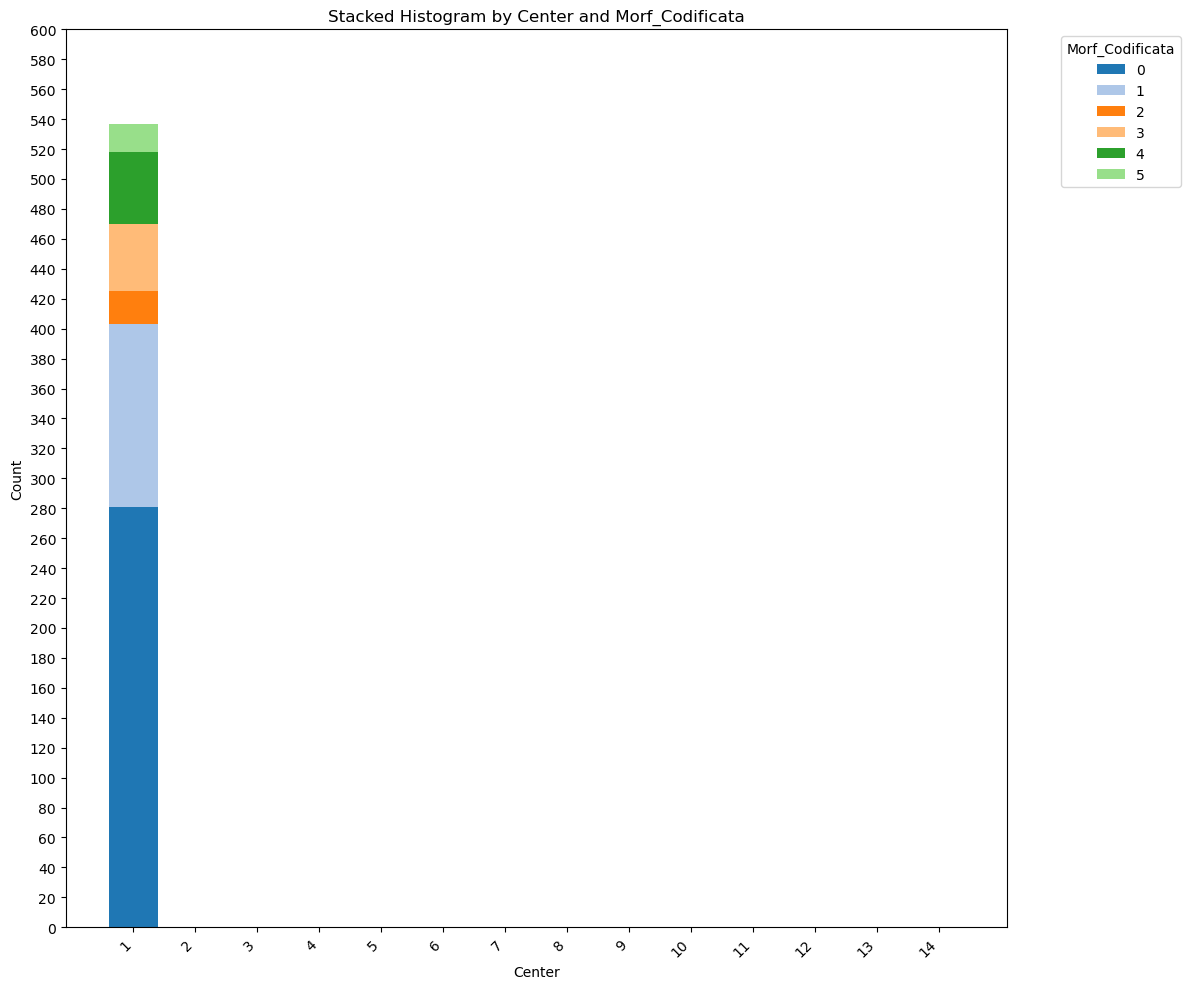

In [12]:
StackedHist(X_train_full)

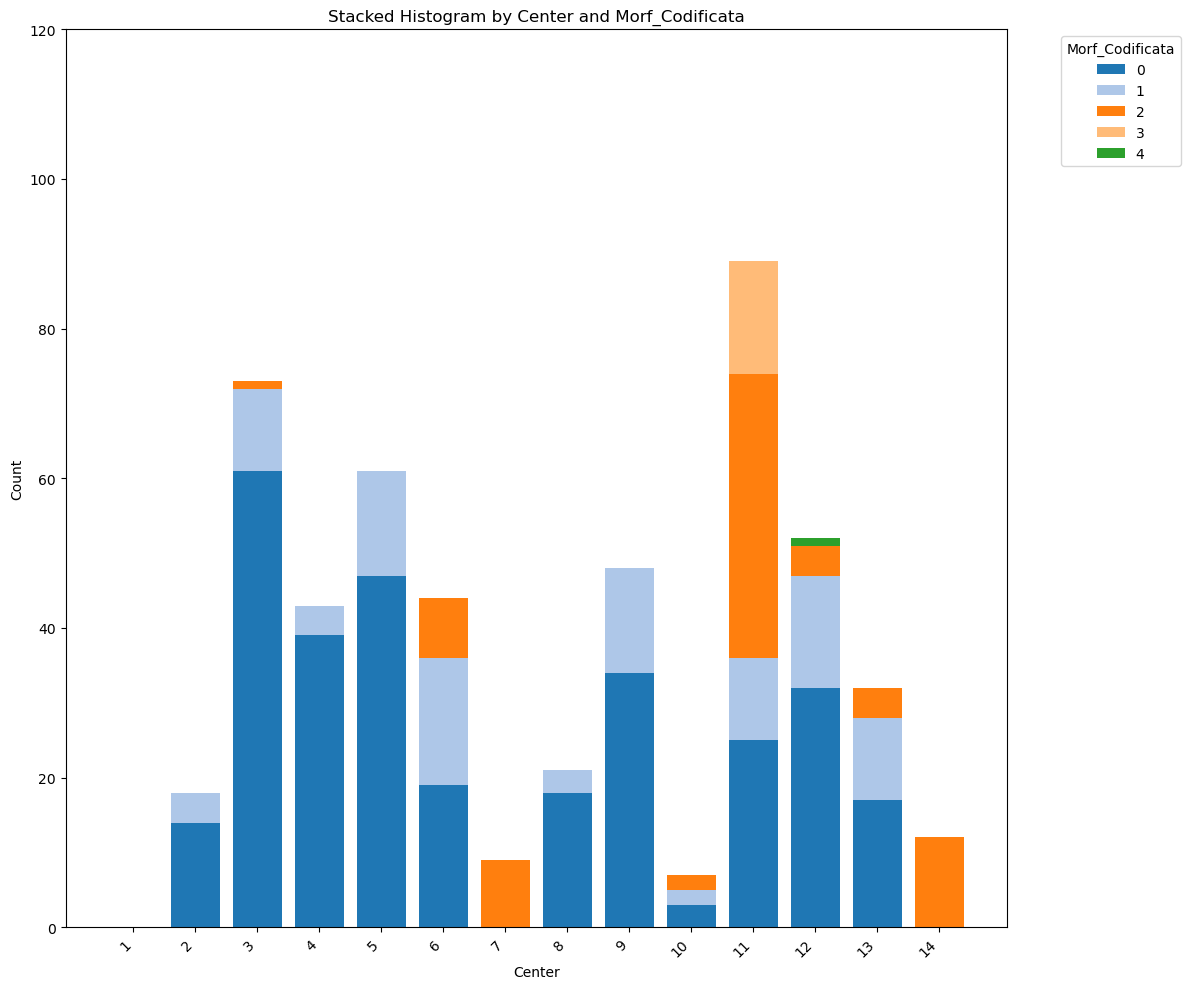

In [13]:
StackedHist(X_test)

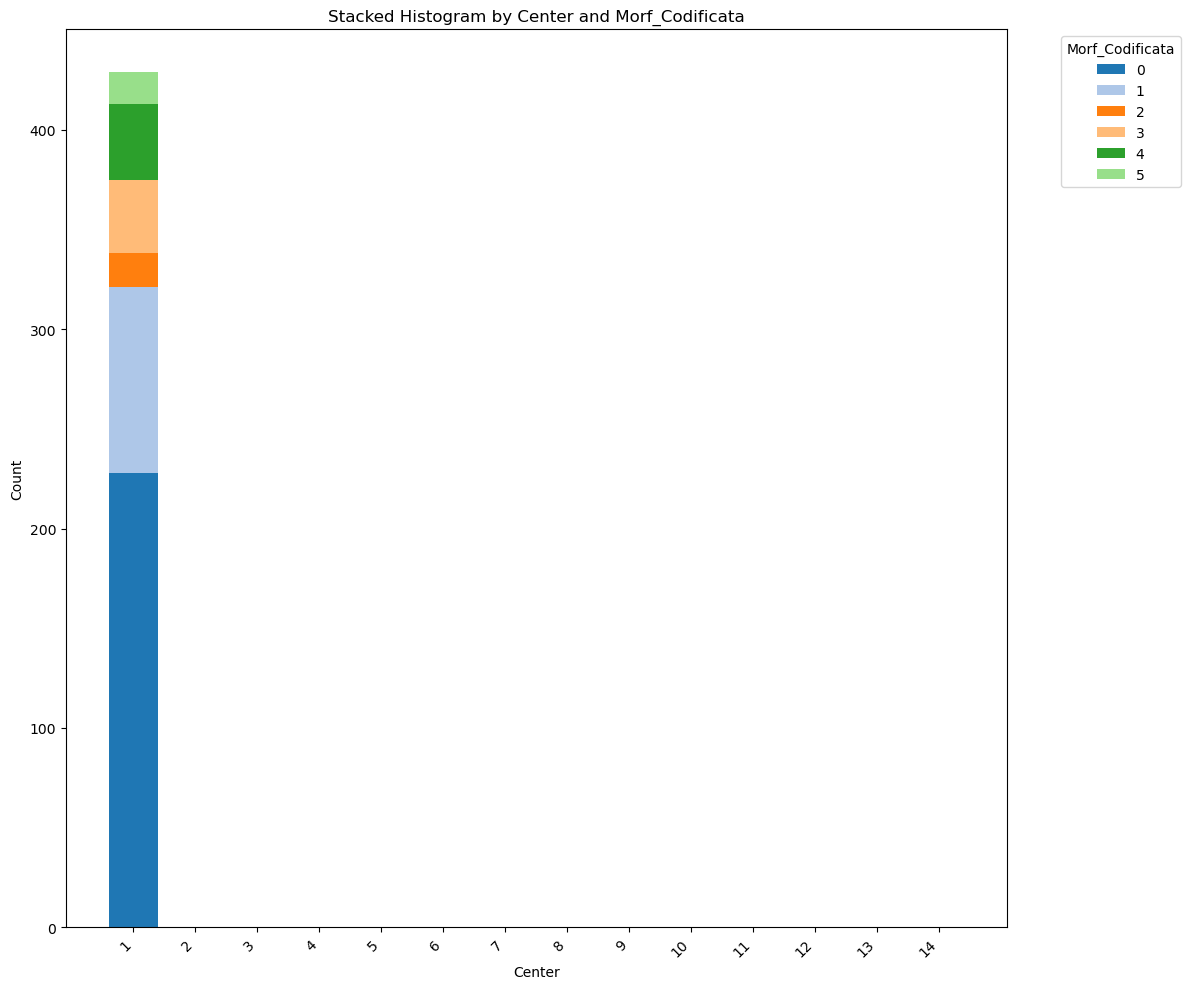

In [20]:
StackedHist(train_folds[0])

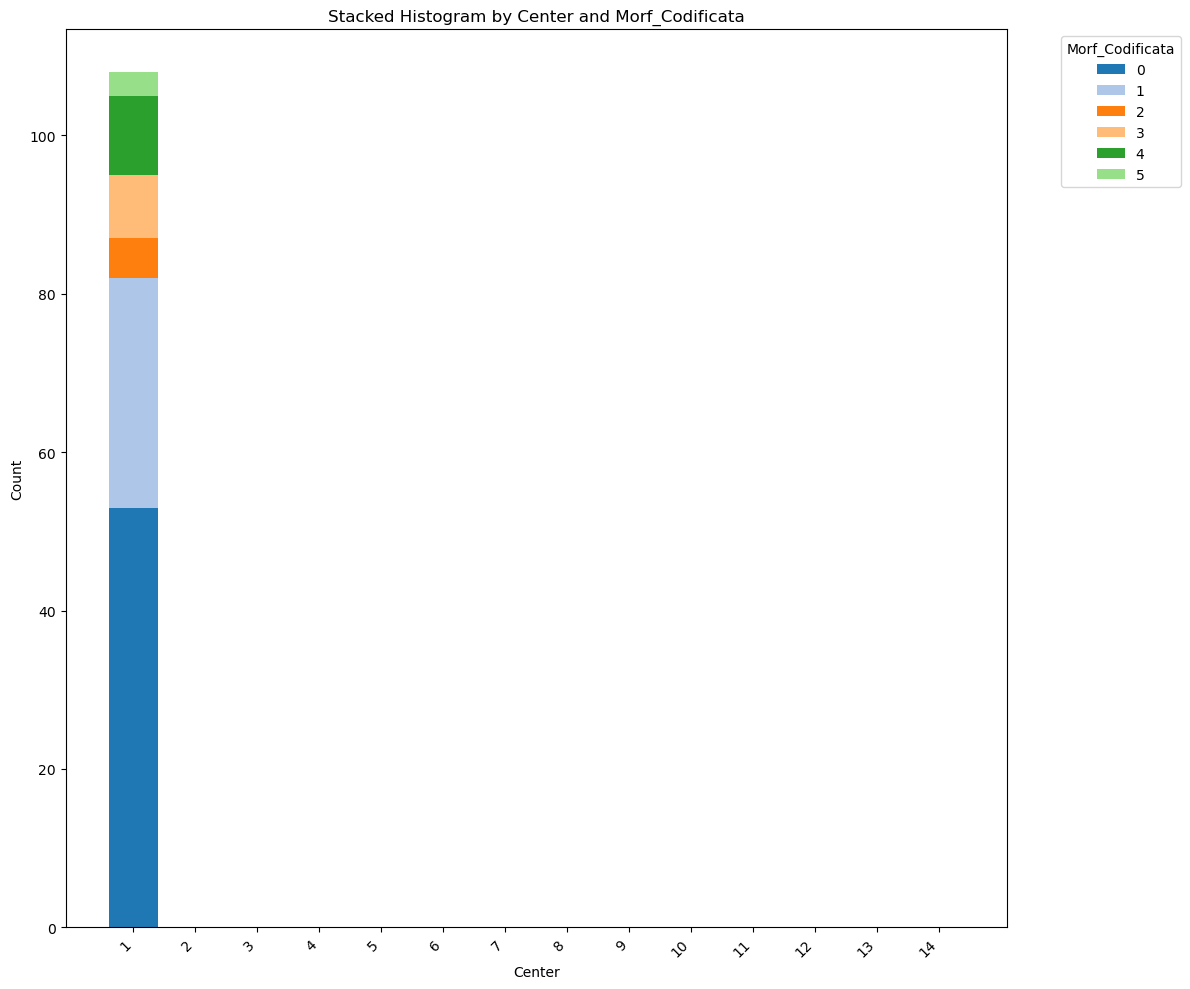

In [21]:
StackedHist(test_folds[0])

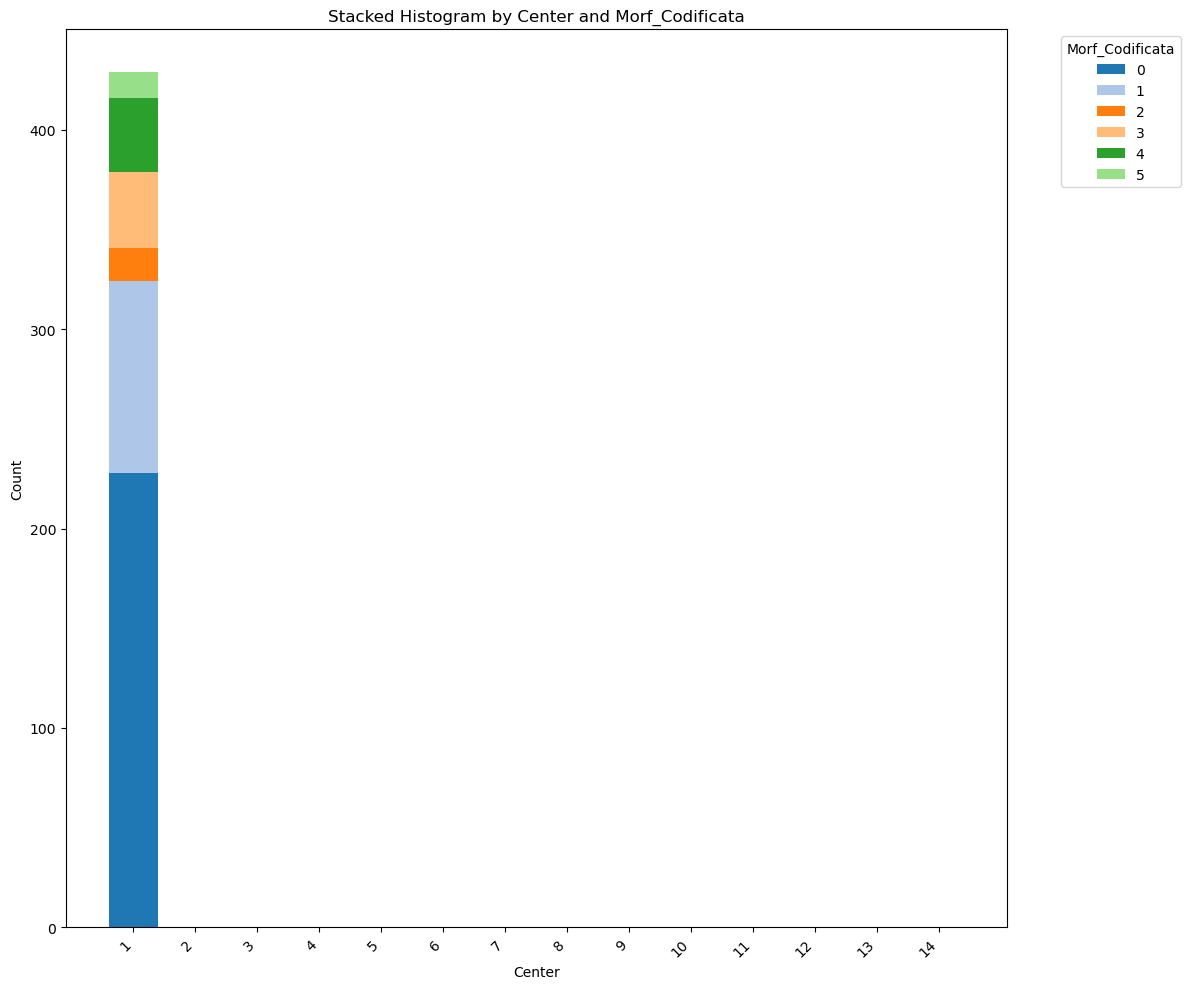

In [22]:
StackedHist(train_folds[1])

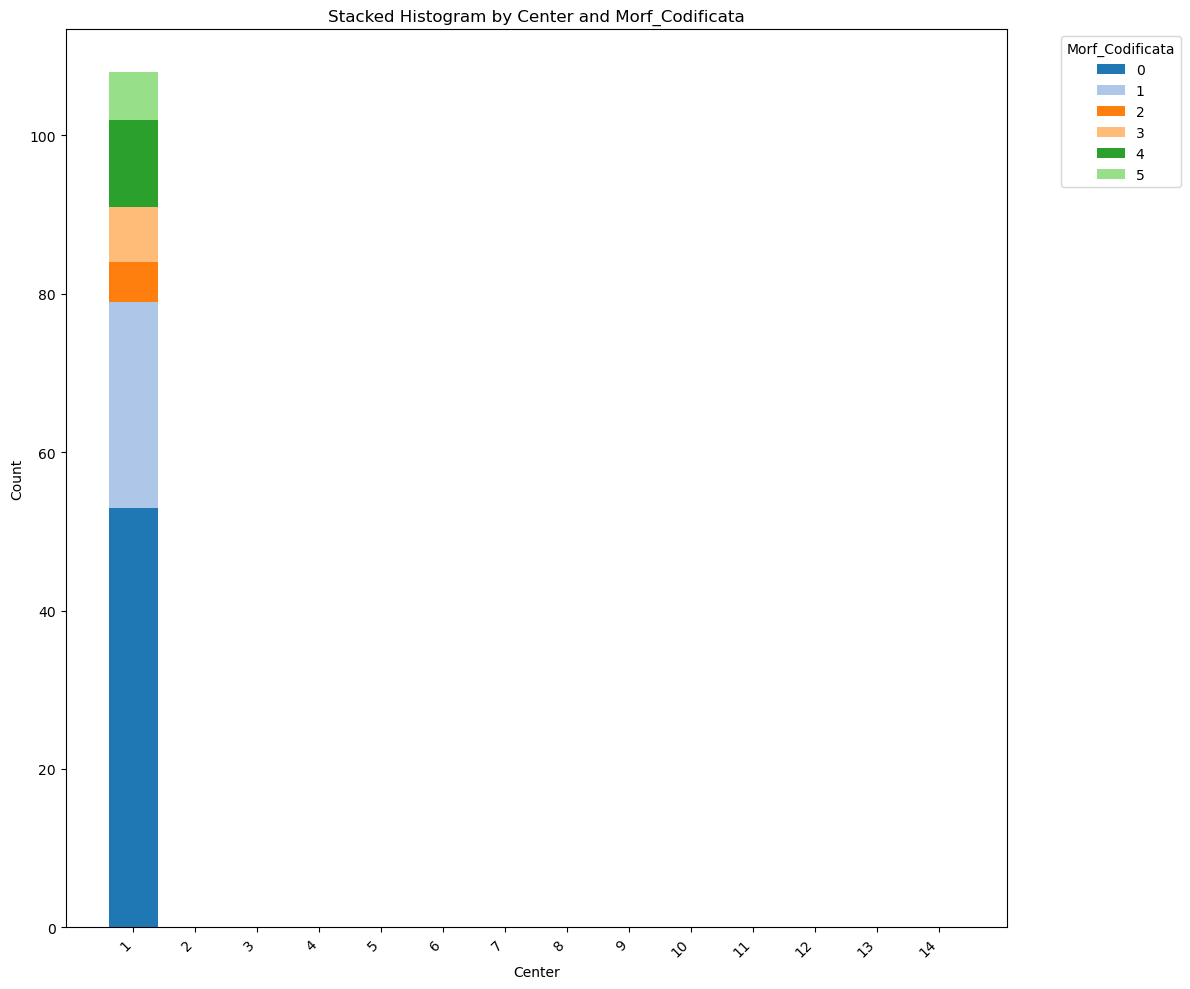

In [23]:
StackedHist(test_folds[1])

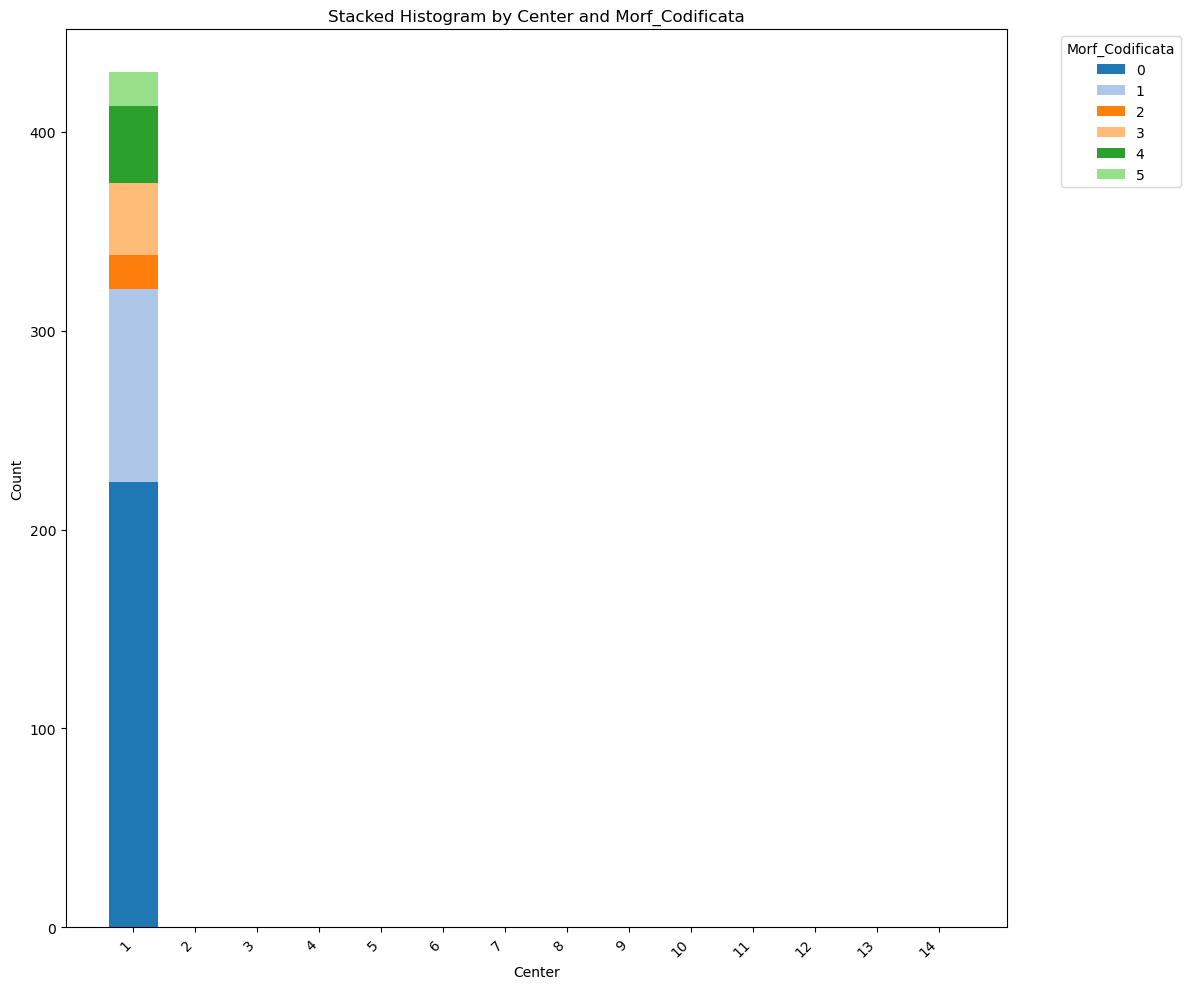

In [24]:
StackedHist(train_folds[2])

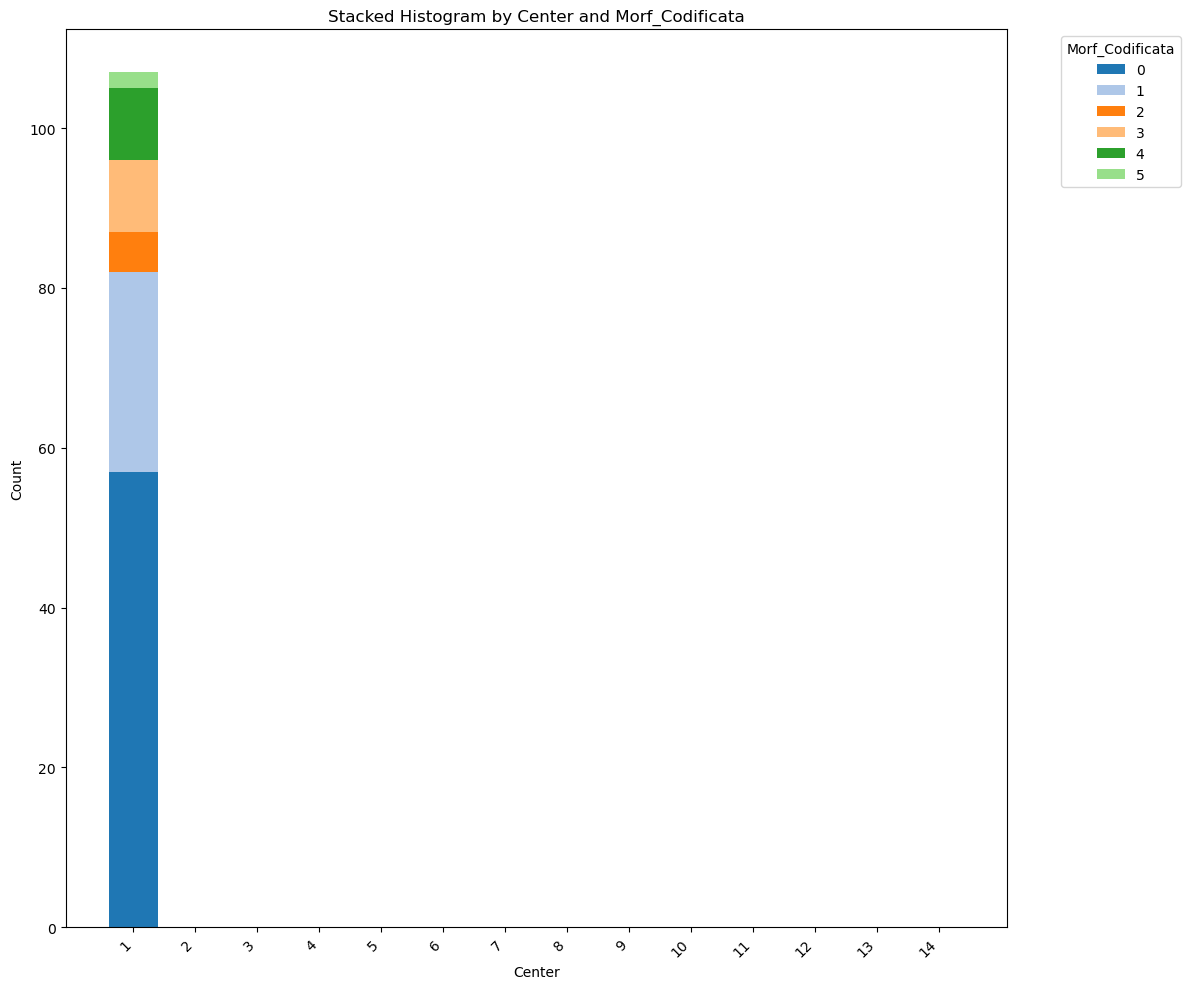

In [25]:
StackedHist(test_folds[2])

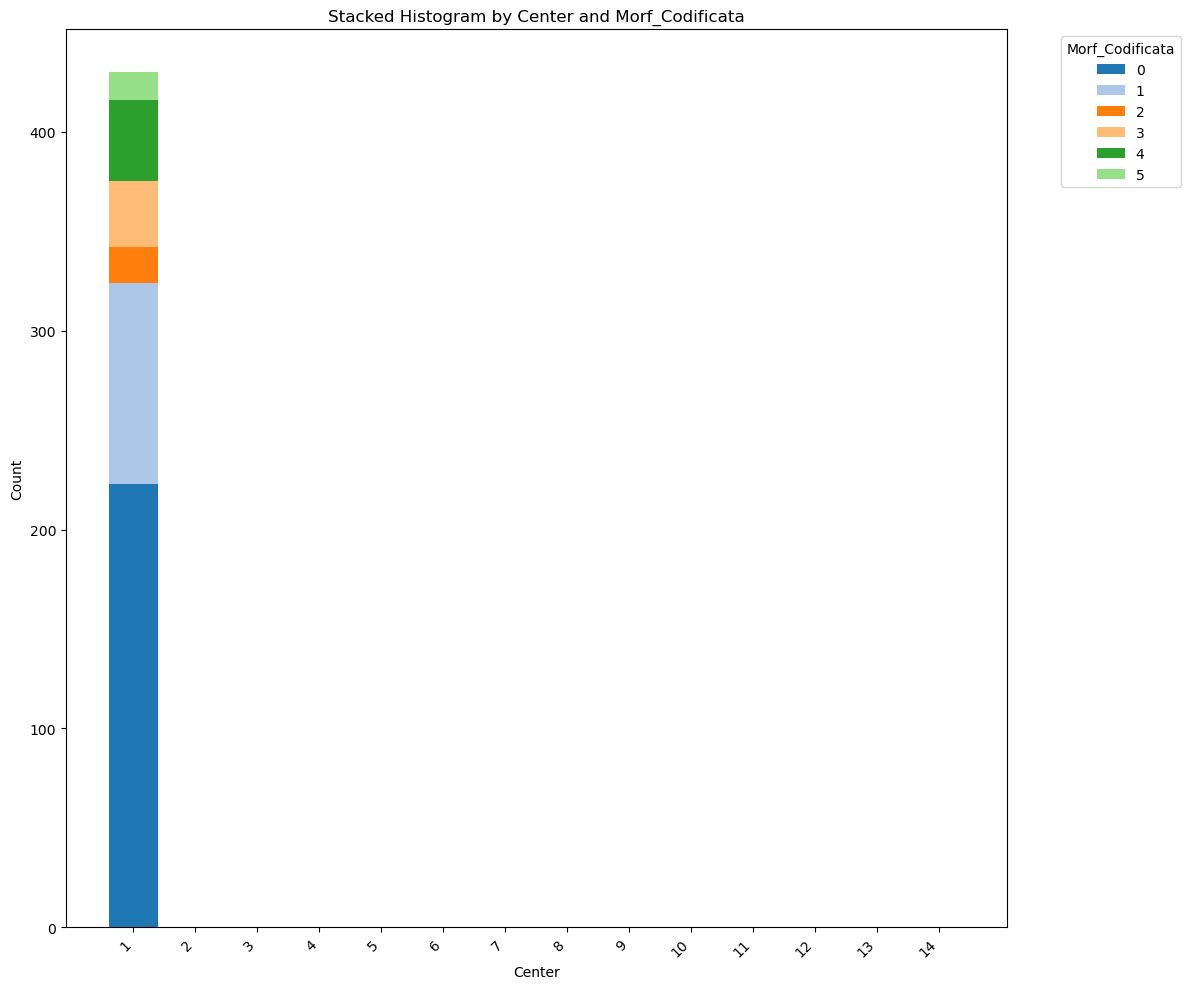

In [26]:
StackedHist(train_folds[3])

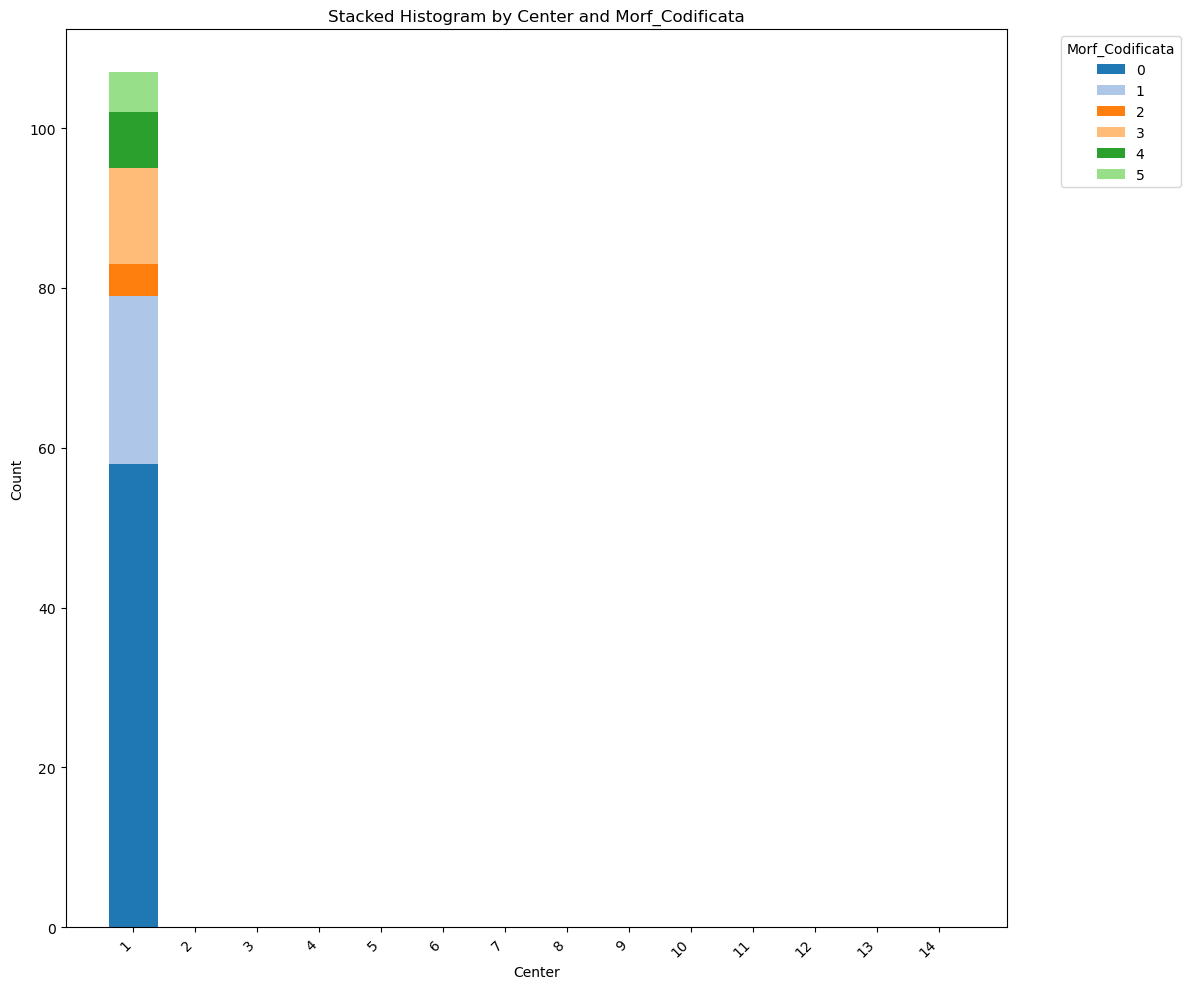

In [27]:
StackedHist(test_folds[3])

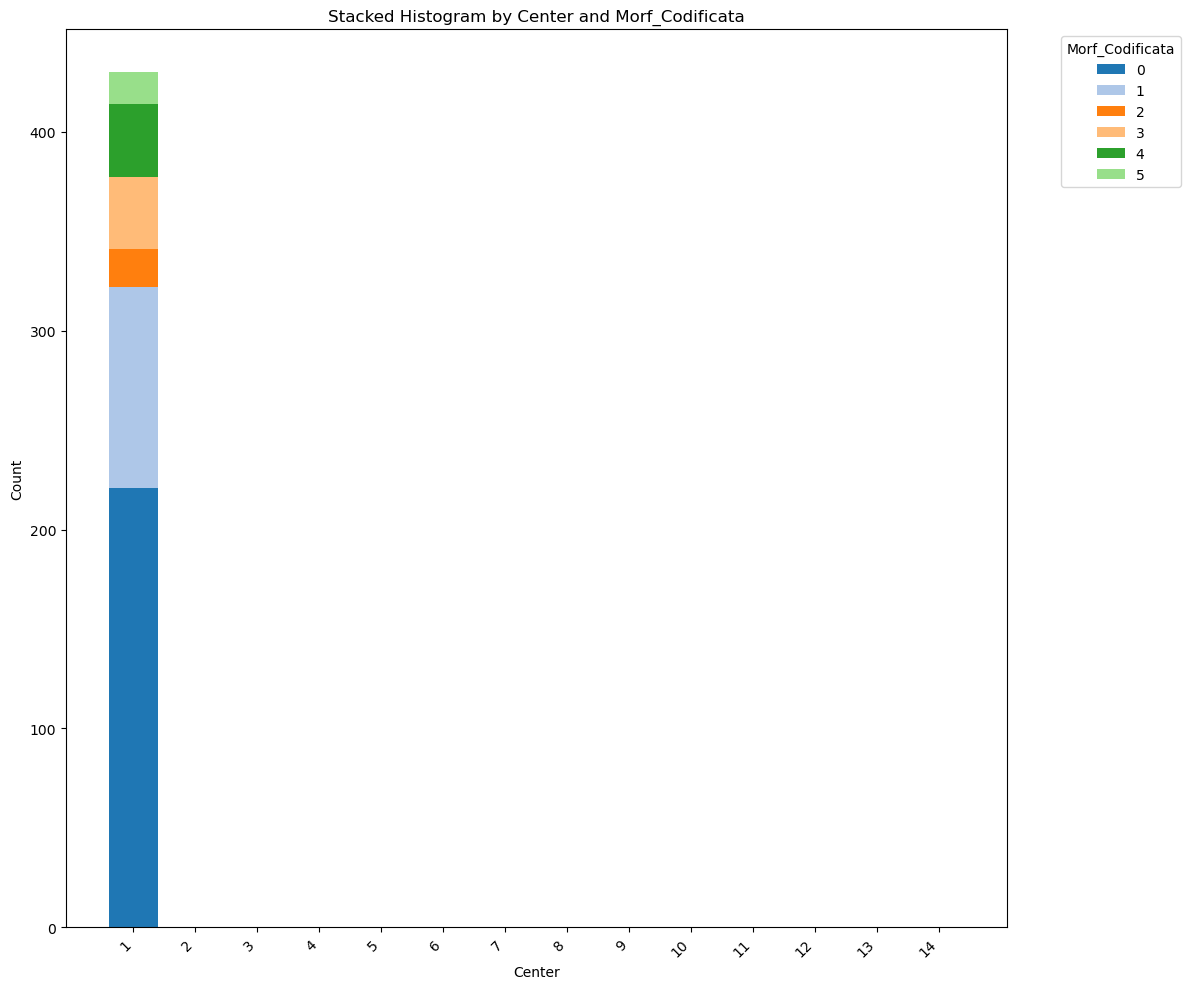

In [28]:
StackedHist(train_folds[4])

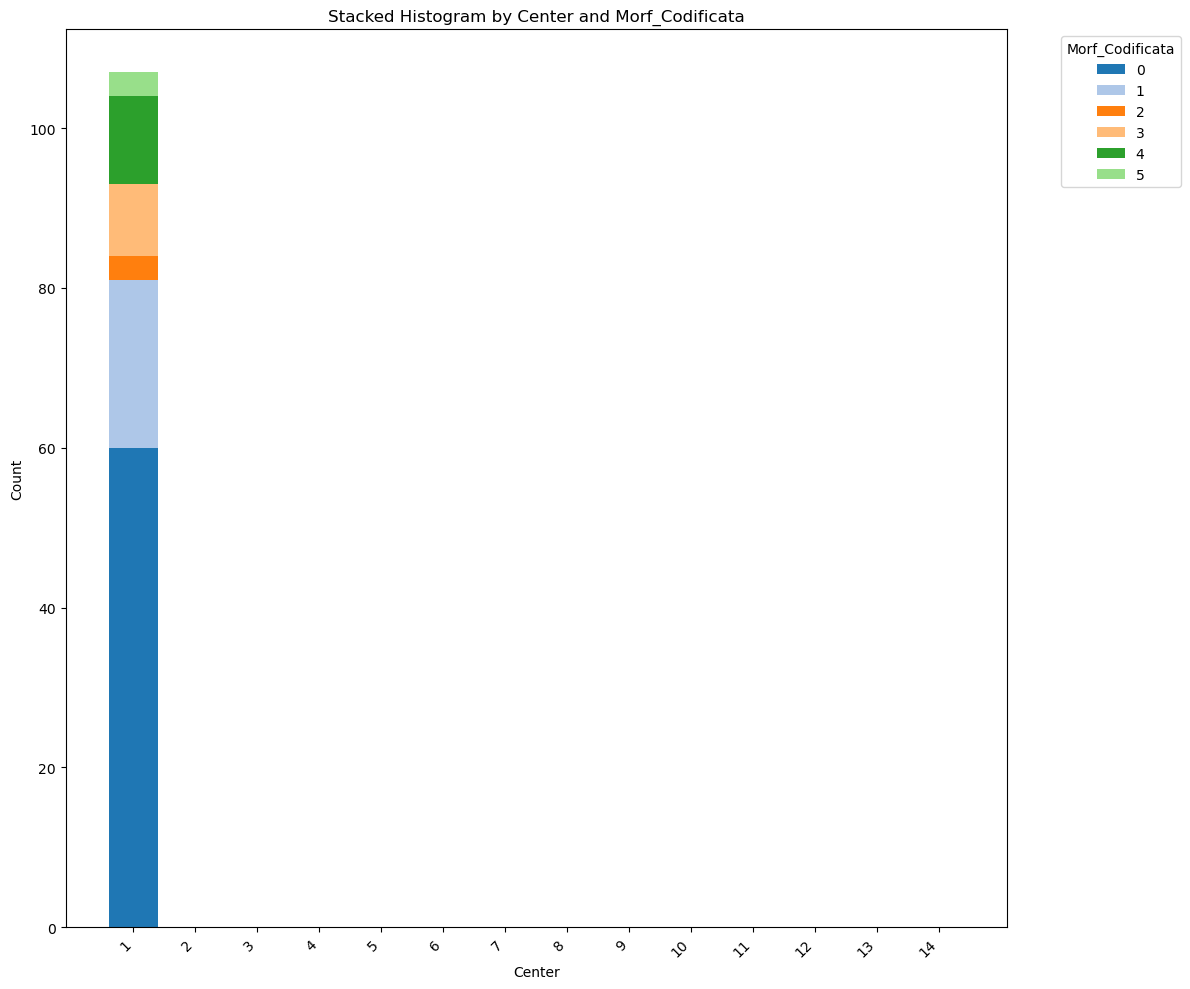

In [29]:
StackedHist(test_folds[4])